In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models
from torchvision.models.vgg import VGG
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import nibabel as nib
import torch.nn.functional as F
import seaborn as sns
from models.unet import UNet
from metrics.torch_seg_metrics import dice_score, iou
from datasets.BRATS2018 import ToTensor, NormalizeBRATS, ZeroPad

%matplotlib inline

In [2]:
def test_inference(base_path, img_name, model_path, device, scan_type='t1ce', seg_type='wt'):
    if seg_type == 'wt':
        model = UNet(n_channels=1, n_classes=1)
    else:
        model = UNet(n_channels=1, n_classes=1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    
    scan_path = os.path.join(base_path, img_name + '_scan.npy')
    mask_path = os.path.join(base_path, img_name + f'_{seg_type}.npy')
    
    if scan_type == 't1ce':
        sc = np.load(scan_path)[1]
        sc = np.expand_dims(sc, axis=0)
        assert sc.shape == (1, 240, 240)
    elif scan_type == 'flair':
        sc = np.load(scan_path)[3]
        sc = np.expand_dims(sc, axis=0)
        assert sc.shape == (1, 240, 240)
    elif scan_type == 't2-flair':
        sc = np.load(scan_path)[2:]
        assert sc.shape == (2, 240, 240)
    else:
        raise ValueError('Scan type should only be t1ze, flair, or t2-flair!')
    mask = np.load(mask_path)
    assert mask.shape == (240, 240)
    
    to_tensor = ToTensor()
    normalize_BraTS = NormalizeBRATS()
    sc, mask = normalize_BraTS((sc, mask))
    sc, mask = to_tensor((sc, mask))
    
    # unsqueeze to 4-dimension NxCxHxW
    sc = torch.unsqueeze(sc, dim=0)
    model.eval()
    with torch.no_grad():
        output = model(sc)
        #pred = torch.argmax(F.softmax(output, dim=1), dim=1)
        pred = torch.sigmoid(output)
        pred = pred > 0.5
    
    # squeeze the dense label back to a 2-dimension tensor
    pred = torch.squeeze(pred)
    
    pred = pred.numpy().astype(np.uint8)
    mask = mask.numpy().astype(np.uint8)
    
    return pred, mask

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
base_path = './BRATS2018/seg/val/'

In [4]:
wt_pred, wt_gt = test_inference(base_path, img_name='Brats18_TCIA04_361_1_084',\
                               model_path='../scores/UNet_BraTS_DiceLoss_WT_manual/UNets-BRATS2018-DiceLoss-WT_batch6_lr1e-5_gamma1.0/terminated_model.pt',\
                               device=device, scan_type='flair', seg_type='wt')

In [5]:
et_pred, et_gt = test_inference(base_path, img_name='Brats18_TCIA04_361_1_084',\
                               model_path='../scores/UNet_BraTS_DiceLoss_ET_manual/UNets-BRATS2018-ET-DiceLoss_batch6_training_epochs50_Adam_scheduler-step10-gamma1.0_lr0.0001_w_decay1e-05/terminated_model.pt',\
                               device=device, scan_type='t1ce', seg_type='et')

In [6]:
tc_pred, tc_gt = test_inference(base_path, img_name='Brats18_TCIA04_361_1_084',\
                               model_path='../scores/UNet_BraTS_DiceLoss_TC_manual/UNets-BRATS2018-TC-DiceLoss_batch6_training_epochs50_Adam_scheduler-step10-gamma1.0_lr1e-05_w_decay1e-05/terminated_model.pt',\
                               device=device, scan_type='t1ce', seg_type='tc')

In [7]:
# for label-2
map_2 = np.logical_xor(wt_gt, tc_gt).astype(np.uint8)
# for label-1
map_1 = np.logical_xor(tc_gt, et_gt).astype(np.uint8)
map_4 = et_gt

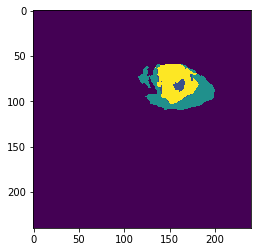

In [8]:
plt.imshow(4*map_4 + 2*map_2 + map_1)

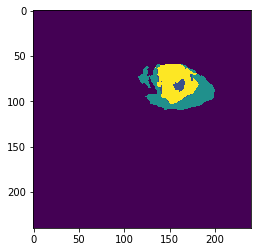

In [28]:
seg = nib.load('BRATS2018/HGG/Brats18_TCIA04_361_1/Brats18_TCIA04_361_1_seg.nii.gz')
seg_np = seg.get_data()
seg_np = seg_np[:, :, 84]
plt.imshow(seg_np)

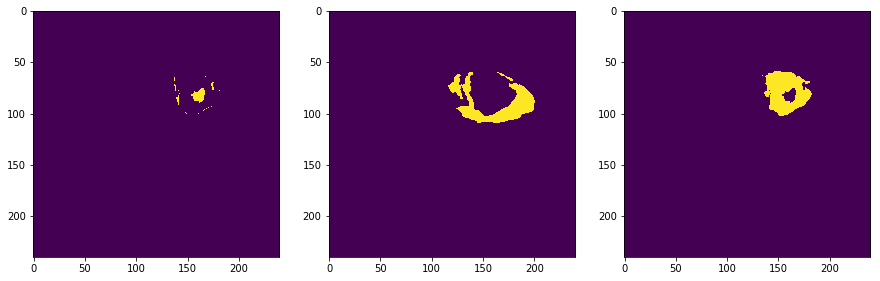

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 25))
ax1.imshow(map_1)
ax2.imshow(map_2)
ax3.imshow(map_4)

In [37]:
pred_2 = np.logical_xor(wt_pred, tc_pred).astype(np.uint8)
pred_1 = np.logical_xor(tc_pred, et_pred).astype(np.uint8)
pred_4 = et_pred
pred = 4 * pred_4 + 2 * pred_2 + pred_1

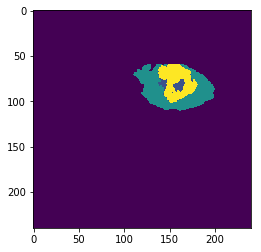

In [44]:
plt.imshow((pred + ((pred > 4).astype(np.uint8) * (4 * np.ones((240, 240)) - pred))))

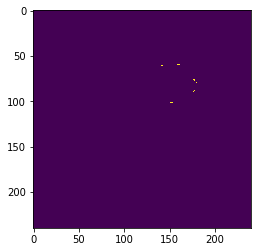

In [33]:
((4 * pred_4 + 2 * pred_2 + pred_1) > 4).astype(np.uint8) * (4 * np.ones())

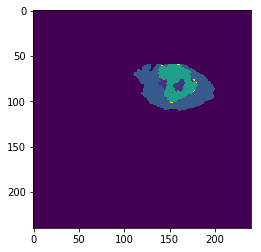

In [39]:
plt.imshow(pred)

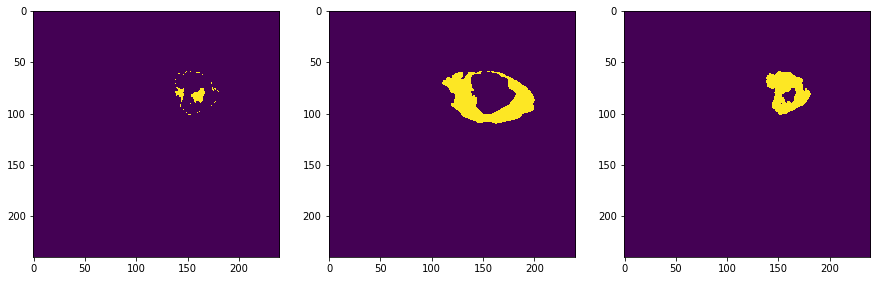

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 25))
ax1.imshow(pred_1)
ax2.imshow(pred_2)
ax3.imshow(pred_4)

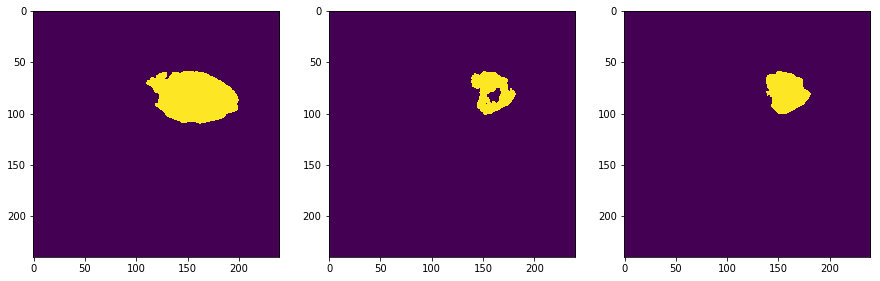

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 25))
ax1.imshow(wt_pred)
ax2.imshow(et_pred)
ax3.imshow(tc_pred)